<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Animate-Plot" data-toc-modified-id="Animate-Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animate Plot</a></span></li><li><span><a href="#Plot-different-events-separately" data-toc-modified-id="Plot-different-events-separately-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot different events separately</a></span></li><li><span><a href="#Write-to-video-file-(or-GIF)" data-toc-modified-id="Write-to-video-file-(or-GIF)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Write to video file (or GIF)</a></span><ul class="toc-item"><li><span><a href="#Write-to-GIF" data-toc-modified-id="Write-to-GIF-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Write to GIF</a></span></li></ul></li></ul></div>

# Matplotlib Version

This version using matplotlib only, actually works. See notebook in the resources folders for more information. Here is a good [blogpost](https://towardsdatascience.com/animations-with-matplotlib-d96375c5442c) exlplaining the code in greater detail and showing different alternatives in Matplotlib.

Prerequisite for writing the result to video: Install FFMPEG, see [here](https://www.wikihow.com/Install-FFmpeg-on-Windows). (If you'd want to save as .gif, then see blogpost reference from above.)


**Data Sources**

- `data/transcript.json`: Interactions for 74'000 customers with the starbucks promo app over 28 days, recorded hourly. The data is from the Starbucks Segmentation Challenge and described there in greater detail.

**Changes**

- 2019-02-26: Start project
- 2019-02-28: Add animation with multiple lines



---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
# %matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Load data
transcript_data = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
print(len(transcript_data))
display(transcript_data.head())

306534


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Prepare Data

In [4]:
transcript_data.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [5]:
transcript_data['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [6]:
# Subset data
transcript = pd.DataFrame(transcript_data.groupby(['time'])['event'].count()).reset_index()

In [7]:
# Check result
assert np.sum(transcript['event']) == len(transcript_data)
print(transcript.shape)
display(transcript.head())

(120, 2)


,time,event
0,0,15561
1,6,2506
2,12,2215
3,18,2015
4,24,1921


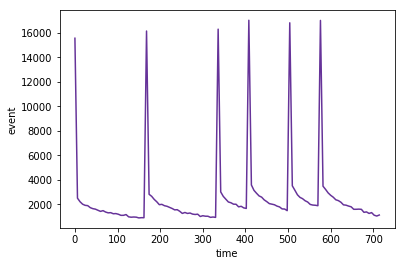

In [8]:
# Make static plot
sns.lineplot(x='time', y='event', data=transcript, color=color);

## Animate Plot

See initial blogpost reference for explanation of the code.

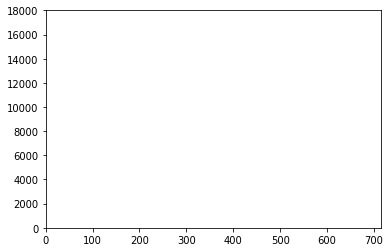

In [9]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim((transcript['time'].min(), transcript['time'].max()))
ax.set_ylim((0, 18000))
line, = ax.plot([], [], lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# Animation function: This is called sequentially
def animate(i):
    data = transcript.iloc[:i+1]
    x = data['time']
    y = data['event']
    line.set_data(x, y)
    return (line,)

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)


In [10]:
HTML(anim.to_html5_video())

---

## Plot different events separately

In [11]:
# Prepare data
transcript_received = transcript_data.loc[transcript_data['event'] == 'offer received']
transcript_transaction = transcript_data.loc[transcript_data['event'] == 'transaction']
transcript_completed = transcript_data.loc[transcript_data['event'] == 'offer completed']
transcript_viewed = transcript_data.loc[transcript_data['event'] == 'offer viewed']

t_received = pd.DataFrame(transcript_received.groupby(['time'])['event'].count()).reset_index()
t_transaction = pd.DataFrame(transcript_transaction.groupby(['time'])['event'].count()).reset_index()
t_completed = pd.DataFrame(transcript_completed.groupby(['time'])['event'].count()).reset_index()
t_viewed = pd.DataFrame(transcript_viewed.groupby(['time'])['event'].count()).reset_index()

In [12]:
for df in [t_received, t_transaction, t_completed, t_viewed]:
    print(len(df))

6
120
120
120


In [13]:
# Augment t_received to len=120
t_rec = pd.merge(t_received, t_completed[['time']], on=['time'], how='outer')
t_received = t_rec.sort_values(['time']).fillna(value=0)

# Check results
t_received.head()

,time,event
0,0,12650.0
6,6,0.0
7,12,0.0
8,18,0.0
9,24,0.0


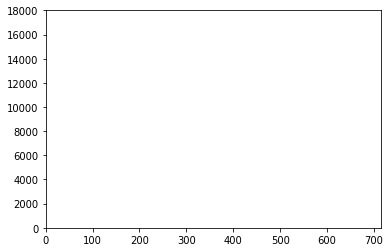

In [14]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim((transcript['time'].min(), transcript['time'].max()))
ax.set_ylim((0, 18000))
line, = ax.plot([], [], lw=2)
line_y1, = ax.plot([], [], lw=2)
line_y2, = ax.plot([], [], lw=2)
line_y3, = ax.plot([], [], lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line_y1.set_data([], [])
    line_y2.set_data([], [])
    line_y3.set_data([], [])
    return line, line_y1, line_y2, line_y3

def animate(i):
    received = t_received.iloc[:i+1]
    transaction = t_transaction.iloc[:i+1]
    completed = t_completed[:i+1]
    viewed = t_viewed[:i+1]

    x1, y1 = received['time'], received['event']
    x2, y2 = transaction['time'], transaction['event']
    x3, y3 = completed['time'], completed['event']
    x4, y4 = viewed['time'], viewed['event']
    
    line.set_data(x1, y1)
    line_y1.set_data(x2, y2)
    line_y2.set_data(x3, y3)
    line_y3.set_data(x4, y4)
    return line, line_y1, line_y2, line_y3

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=120, interval=100, blit=True)



In [15]:
HTML(anim.to_html5_video())

---

## Write to video file (or GIF)

Next: Initialize a writer which uses ffmpeg and records at 20 fps with a bitrate of 1800. (You can of course pick these values yourself.)

In [16]:
# Check available writers
print('animation writers:', animation.writers.list())

animation writers: ['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


In [17]:
# Initialize Writer Object
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [18]:
# Save to mp4
anim.save('events.mp4', writer=writer)

### Write to GIF

In [19]:
# # Create gif from animation (uses ImageMagick)
# gif_path = './gradient_descent.gif'
# anim.save('./gradient_descent.gif', writer='imagemagick', fps=1000/800)
# Image(url=gif_path)